In [1]:
## Install some important non-default libraries
# !pip install networkx matplotlib
# !pip install wordcloud

In [2]:
import pandas as pd 
import seaborn as sns
import numpy as np
from sklearn.preprocessing import LabelEncoder
from collections import defaultdict

chess_data = pd.read_csv("chess_games.csv")
chess_data.head(5)

,game_id,rated,turns,victory_status,winner,time_increment,white_id,white_rating,black_id,black_rating,moves,opening_code,opening_moves,opening_fullname,opening_shortname,opening_response,opening_variation
0,1,False,13,Out of Time,White,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,5,Slav Defense: Exchange Variation,Slav Defense,NaN,Exchange Variation
1,2,True,16,Resign,Black,5+10,a-00,1322,skinnerua,1261,d4 Nc6 e4 e5 f4 f6 dxe5 fxe5 fxe5 Nxe5 Qd4 Nc6...,B00,4,Nimzowitsch Defense: Kennedy Variation,Nimzowitsch Defense,NaN,Kennedy Variation
2,3,True,61,Mate,White,5+10,ischia,1496,a-00,1500,e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,C20,3,King's Pawn Game: Leonardis Variation,King's Pawn Game,NaN,Leonardis Variation
3,4,True,61,Mate,White,20+0,daniamurashov,1439,adivanov2009,1454,d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,D02,3,Queen's Pawn Game: Zukertort Variation,Queen's Pawn Game,NaN,Zukertort Variation
4,5,True,95,Mate,White,30+3,nik221107,1523,adivanov2009,1469,e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,C41,5,Philidor Defense,Philidor Defense,NaN,NaN


In [3]:
chess_moves = pd.read_csv("chess_moves_codes.csv", engine='python')
chess_moves.head(10)

,Moves,Codes
0,Polish (Sokolsky) opening,b4
1,"Polish, Tuebingen variation",b4 Nh6
2,"Polish, Outflank variation",b4 c6
3,Benko's opening,g3
4,Lasker simul special,g3 h5
5,"Benko's opening, reversed Alekhine",g3 e5 2. Nf3
6,Grob's attack,g4
7,"Grob, spike attack",g4 d5 2. Bg2 c6 3. g5
8,"Grob, Fritz gambit",g4 d5 2. Bg2 Bxg4 3. c4
9,"Grob, Romford counter-gambit",g4 d5 2. Bg2 Bxg4 3. c4 d4


In [4]:
import re

# Create a regex pattern to match move codes
pattern = '|'.join(r'\b{}\b'.format(re.escape(x)) for x in chess_moves['Codes'])

# Function to extract move names
def extract_move_name(row):
    moves = re.findall(pattern, row['moves'])
    return ', '.join(chess_moves[chess_moves['Codes'].isin(moves)]['Moves'])

# Apply the function to create the 'Move Name' column in chess_data
chess_data['Move Name'] = chess_data.apply(extract_move_name, axis=1)
chess_data['Move Name'][0] = 'Queen Gambit'

/tmp/ipykernel_162/4212436983.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  chess_data['Move Name'][0] = 'Queen Gambit'


In [5]:
chess_data_subset = chess_data[['Move Name','moves','opening_fullname','victory_status','winner']].copy()
chess_data_subset= chess_data_subset[chess_data_subset['victory_status']== 'Mate']

In [6]:
chess_data_subset.head(5)

,Move Name,moves,opening_fullname,victory_status,winner
2,"Anderssen's opening, Ware (Meadow Hay) openi...",e4 e5 d3 d6 Be3 c6 Be2 b5 Nd2 a5 a4 c5 axb5 Nc...,King's Pawn Game: Leonardis Variation,Mate,White
3,"Benko's opening, Dunst (Sleipner, Heinrichse...",d4 d5 Nf3 Bf5 Nc3 Nf6 Bf4 Ng4 e3 Nc6 Be2 Qd7 O...,Queen's Pawn Game: Zukertort Variation,Mate,White
4,"Polish (Sokolsky) opening, Dunst (Sleipner, ...",e4 e5 Nf3 d6 d4 Nc6 d5 Nb4 a3 Na6 Nc3 Be7 b4 N...,Philidor Defense,Mate,White
9,"Polish (Sokolsky) opening, Clemenz (Mead's, ...",e4 d5 exd5 Qxd5 Nc3 Qe5+ Be2 Na6 d4 Qf5 Bxa6 b...,Scandinavian Defense: Mieses-Kotroc Variation,Mate,White
10,"Dunst (Sleipner, Heinrichsen) opening, King'...",e3 e6 d4 d6 Bd3 c6 Nf3 Be7 Nc3 Nf6 Bd2 Bd7 Qe2...,Van't Kruijs Opening,Mate,White


# Sequence of Moves

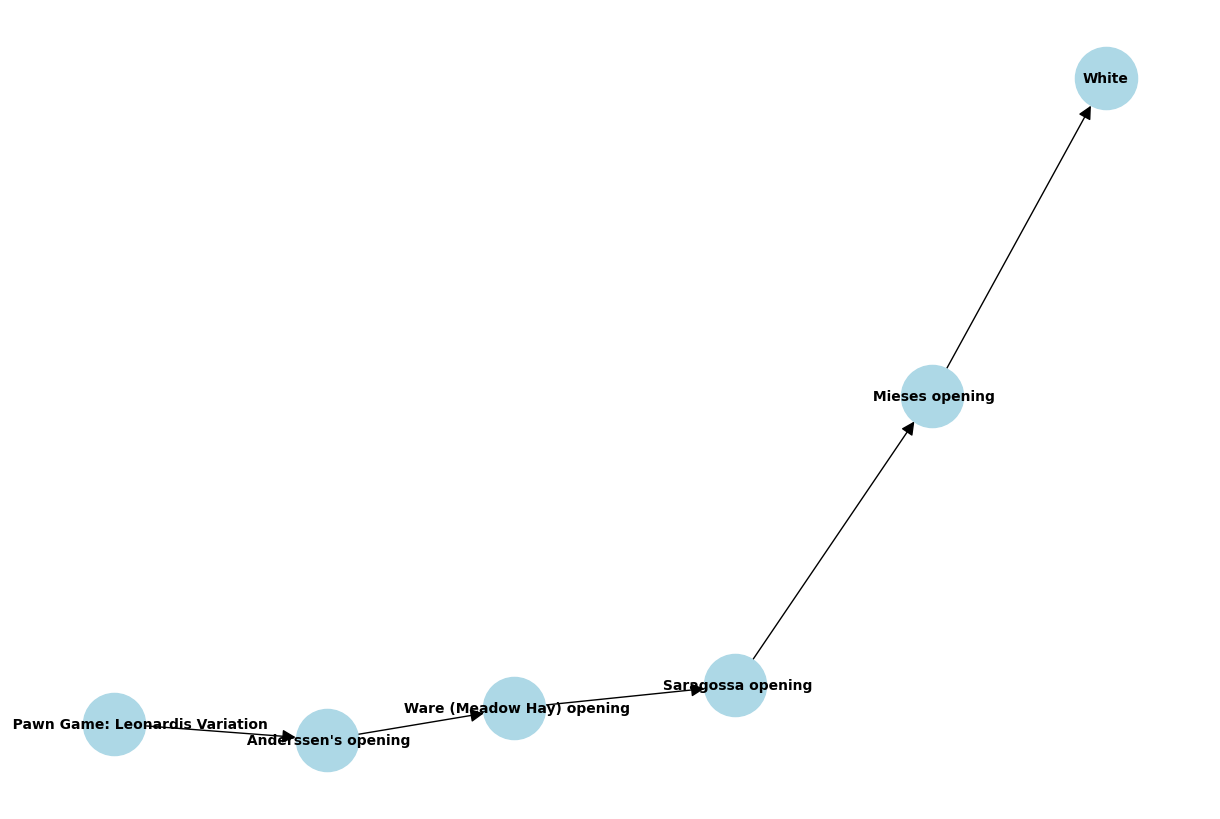

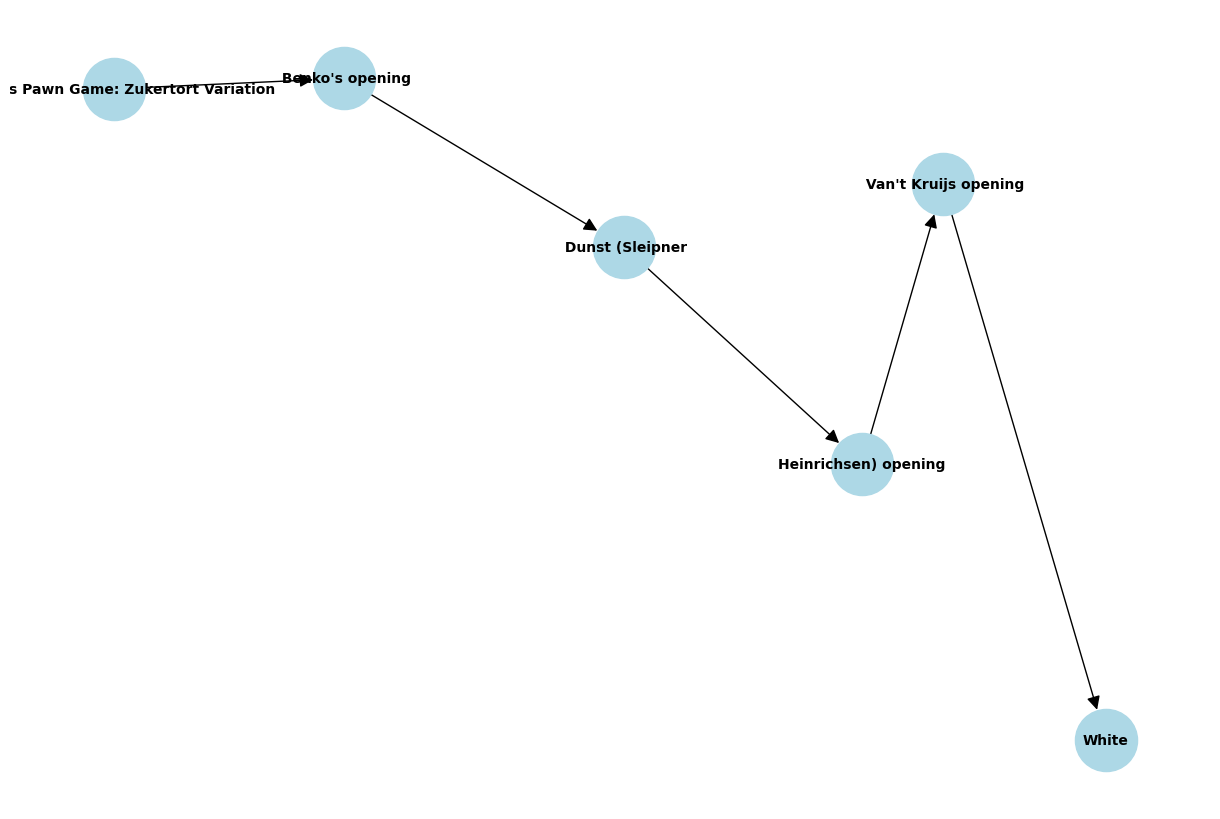

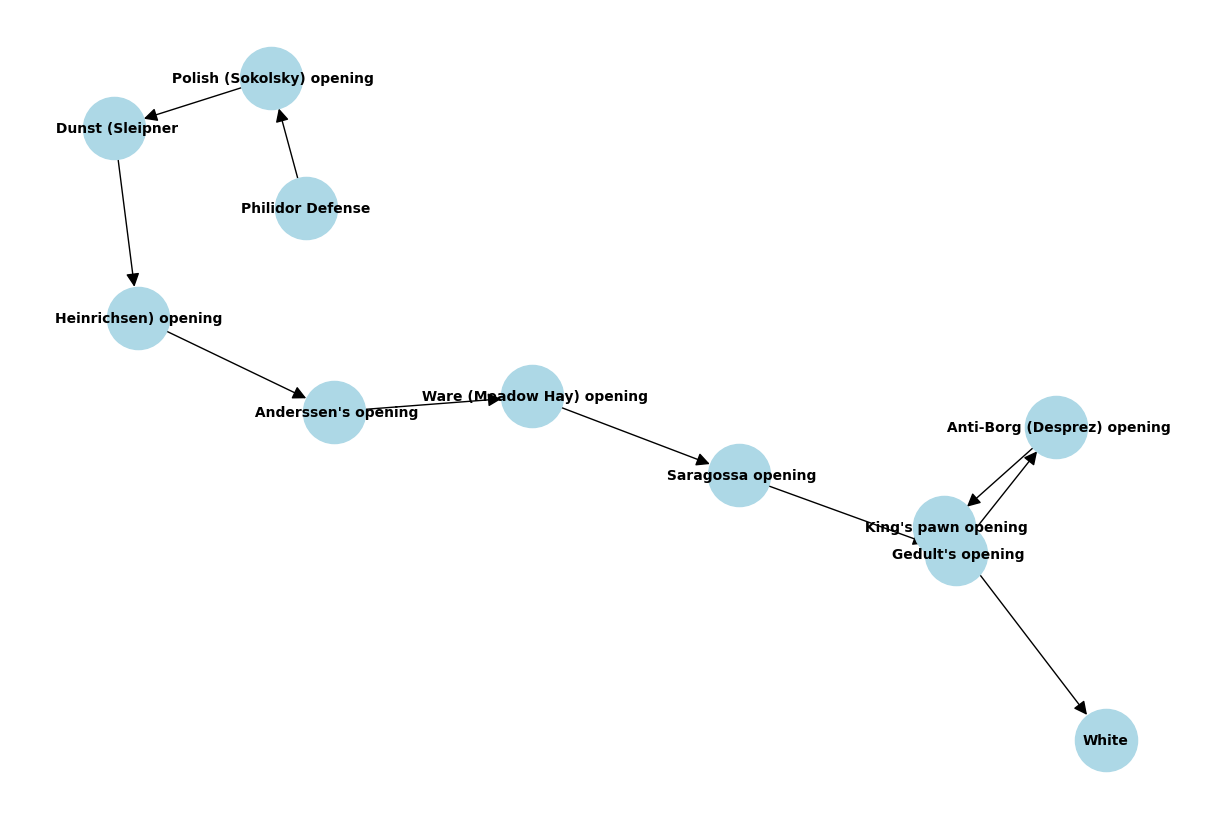

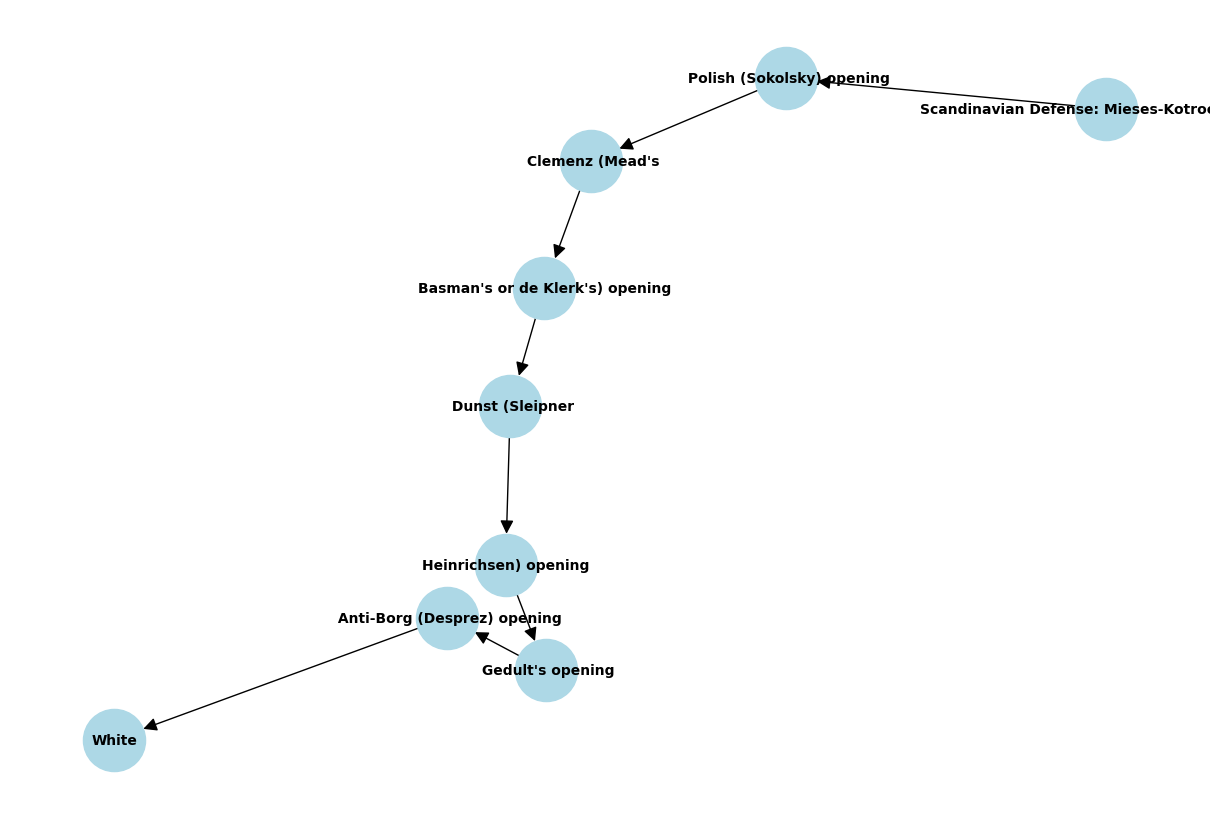

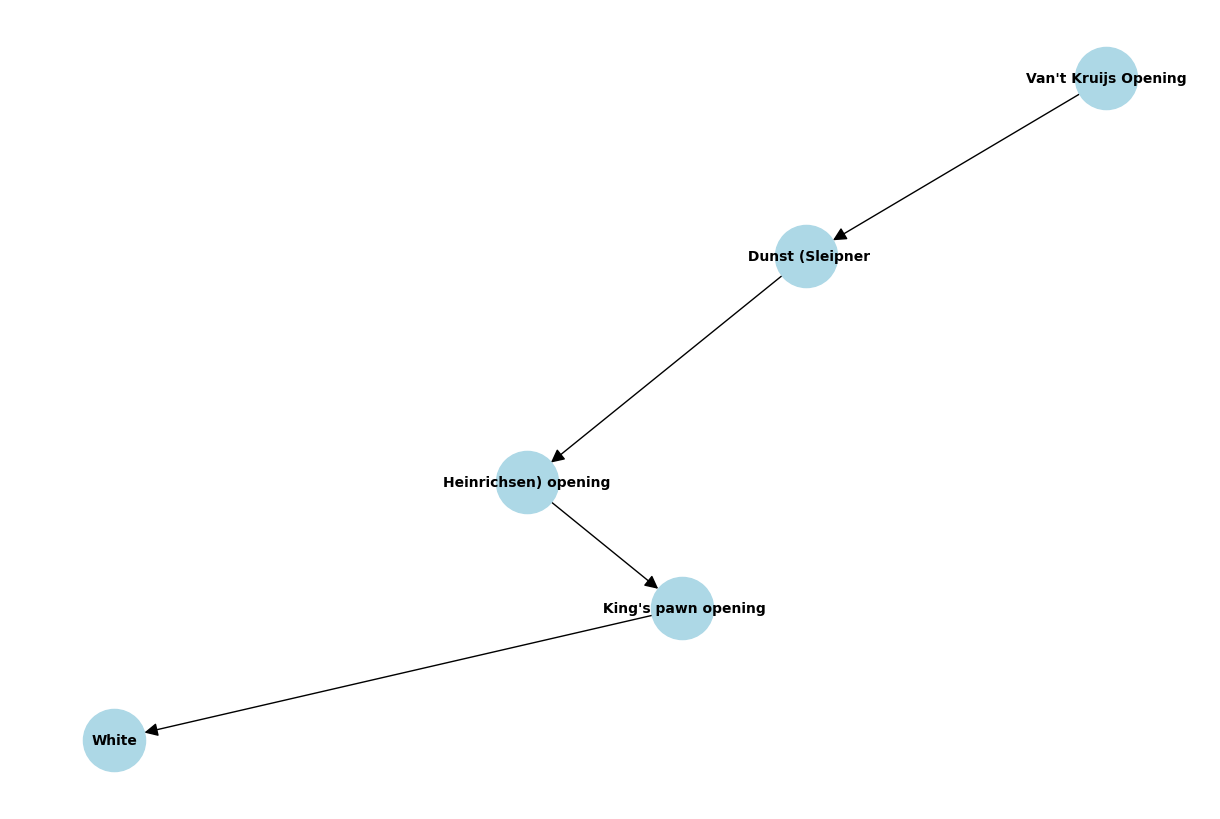

In [7]:
########################## Illustrating the Sequence of Moves for both White and Black ####################################

import networkx as nx
import matplotlib.pyplot as plt

def plot_network_for_each_record(dataframe):
    import matplotlib.pyplot as plt
    import networkx as nx

    for index, row in dataframe.iterrows():
        g = nx.DiGraph()
        opening = row['opening_fullname']
        winner = row['winner']
        moves_sequence = row['Move Name'].split(', ')

        if opening not in g:
            g.add_node(opening)

        current_node = opening
        for move in moves_sequence:
            next_node = f'{move}'
            g.add_edge(current_node, next_node)
            current_node = next_node

        g.add_edge(current_node, winner)

        plt.figure(figsize=(12, 8))
        nx.draw(g, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, font_weight='bold', arrowstyle='-|>', arrowsize=20)
        plt.show()

# Call the function with a subset of the dataframe to avoid generating too many graphs
plot_network_for_each_record(chess_data_subset.head(5))

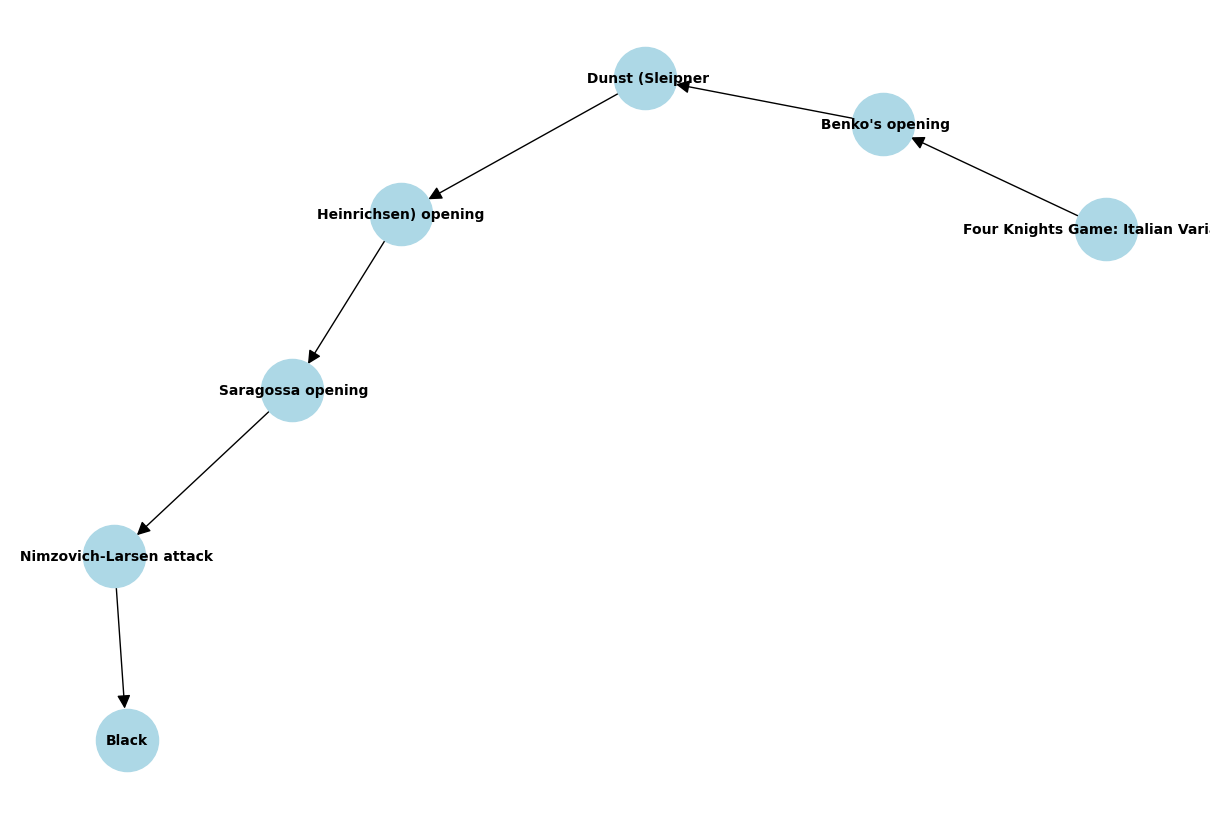

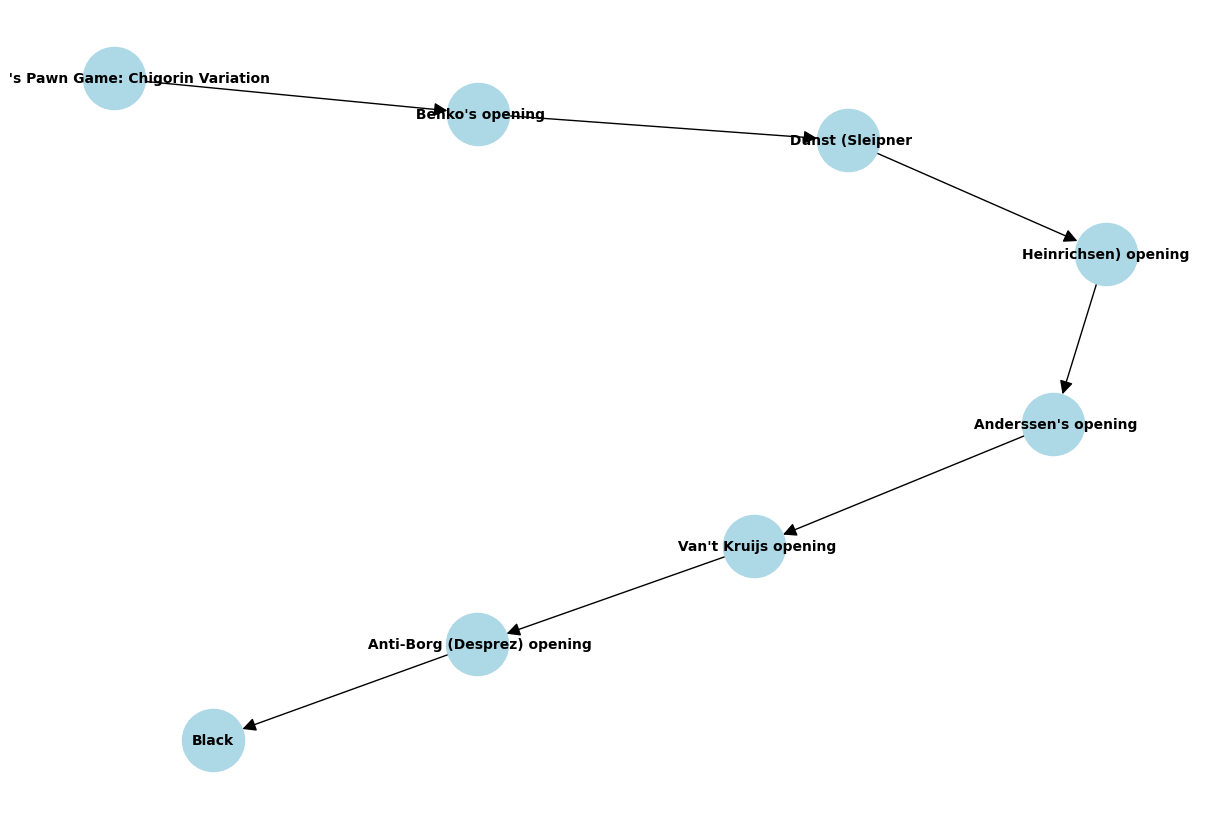

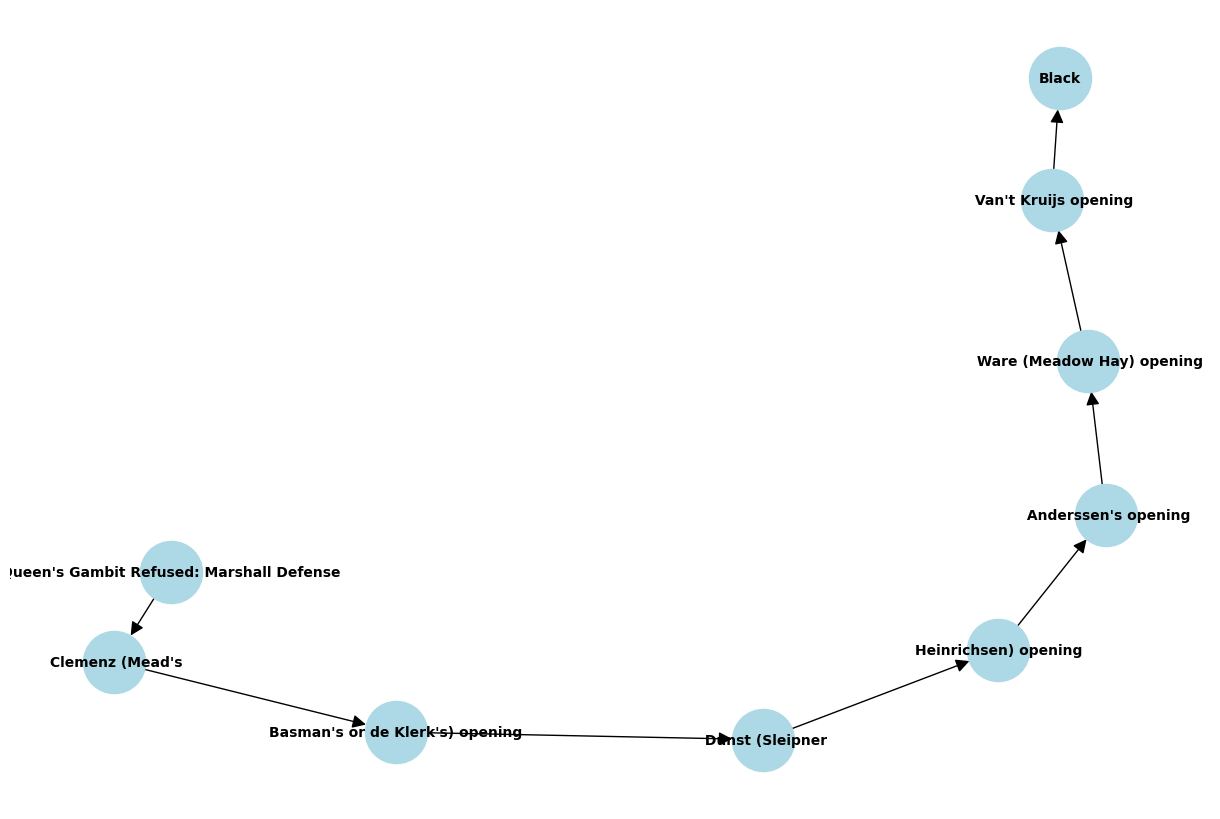

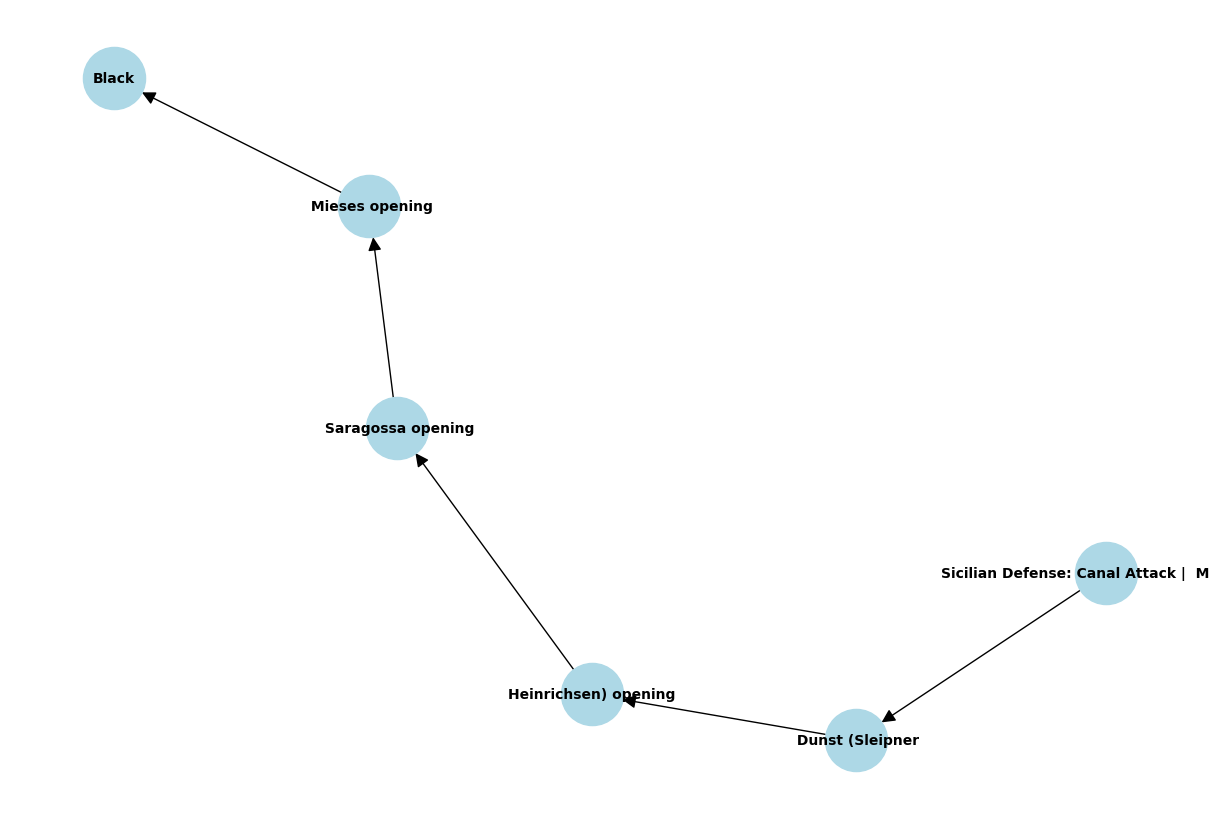

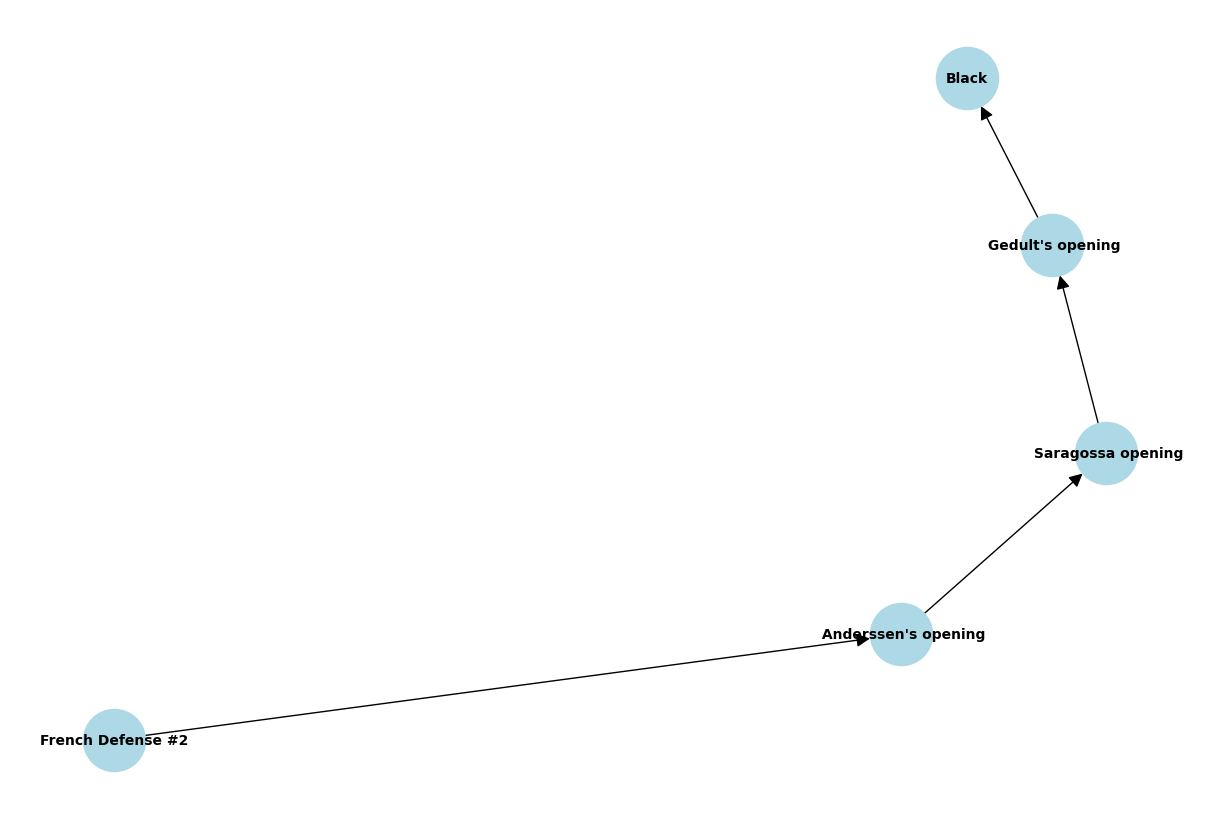

In [8]:
plot_network_for_each_record(chess_data_subset[chess_data_subset['winner']=='Black'].head(5))

# Opening Moves: Does it guarantee a check-mate?

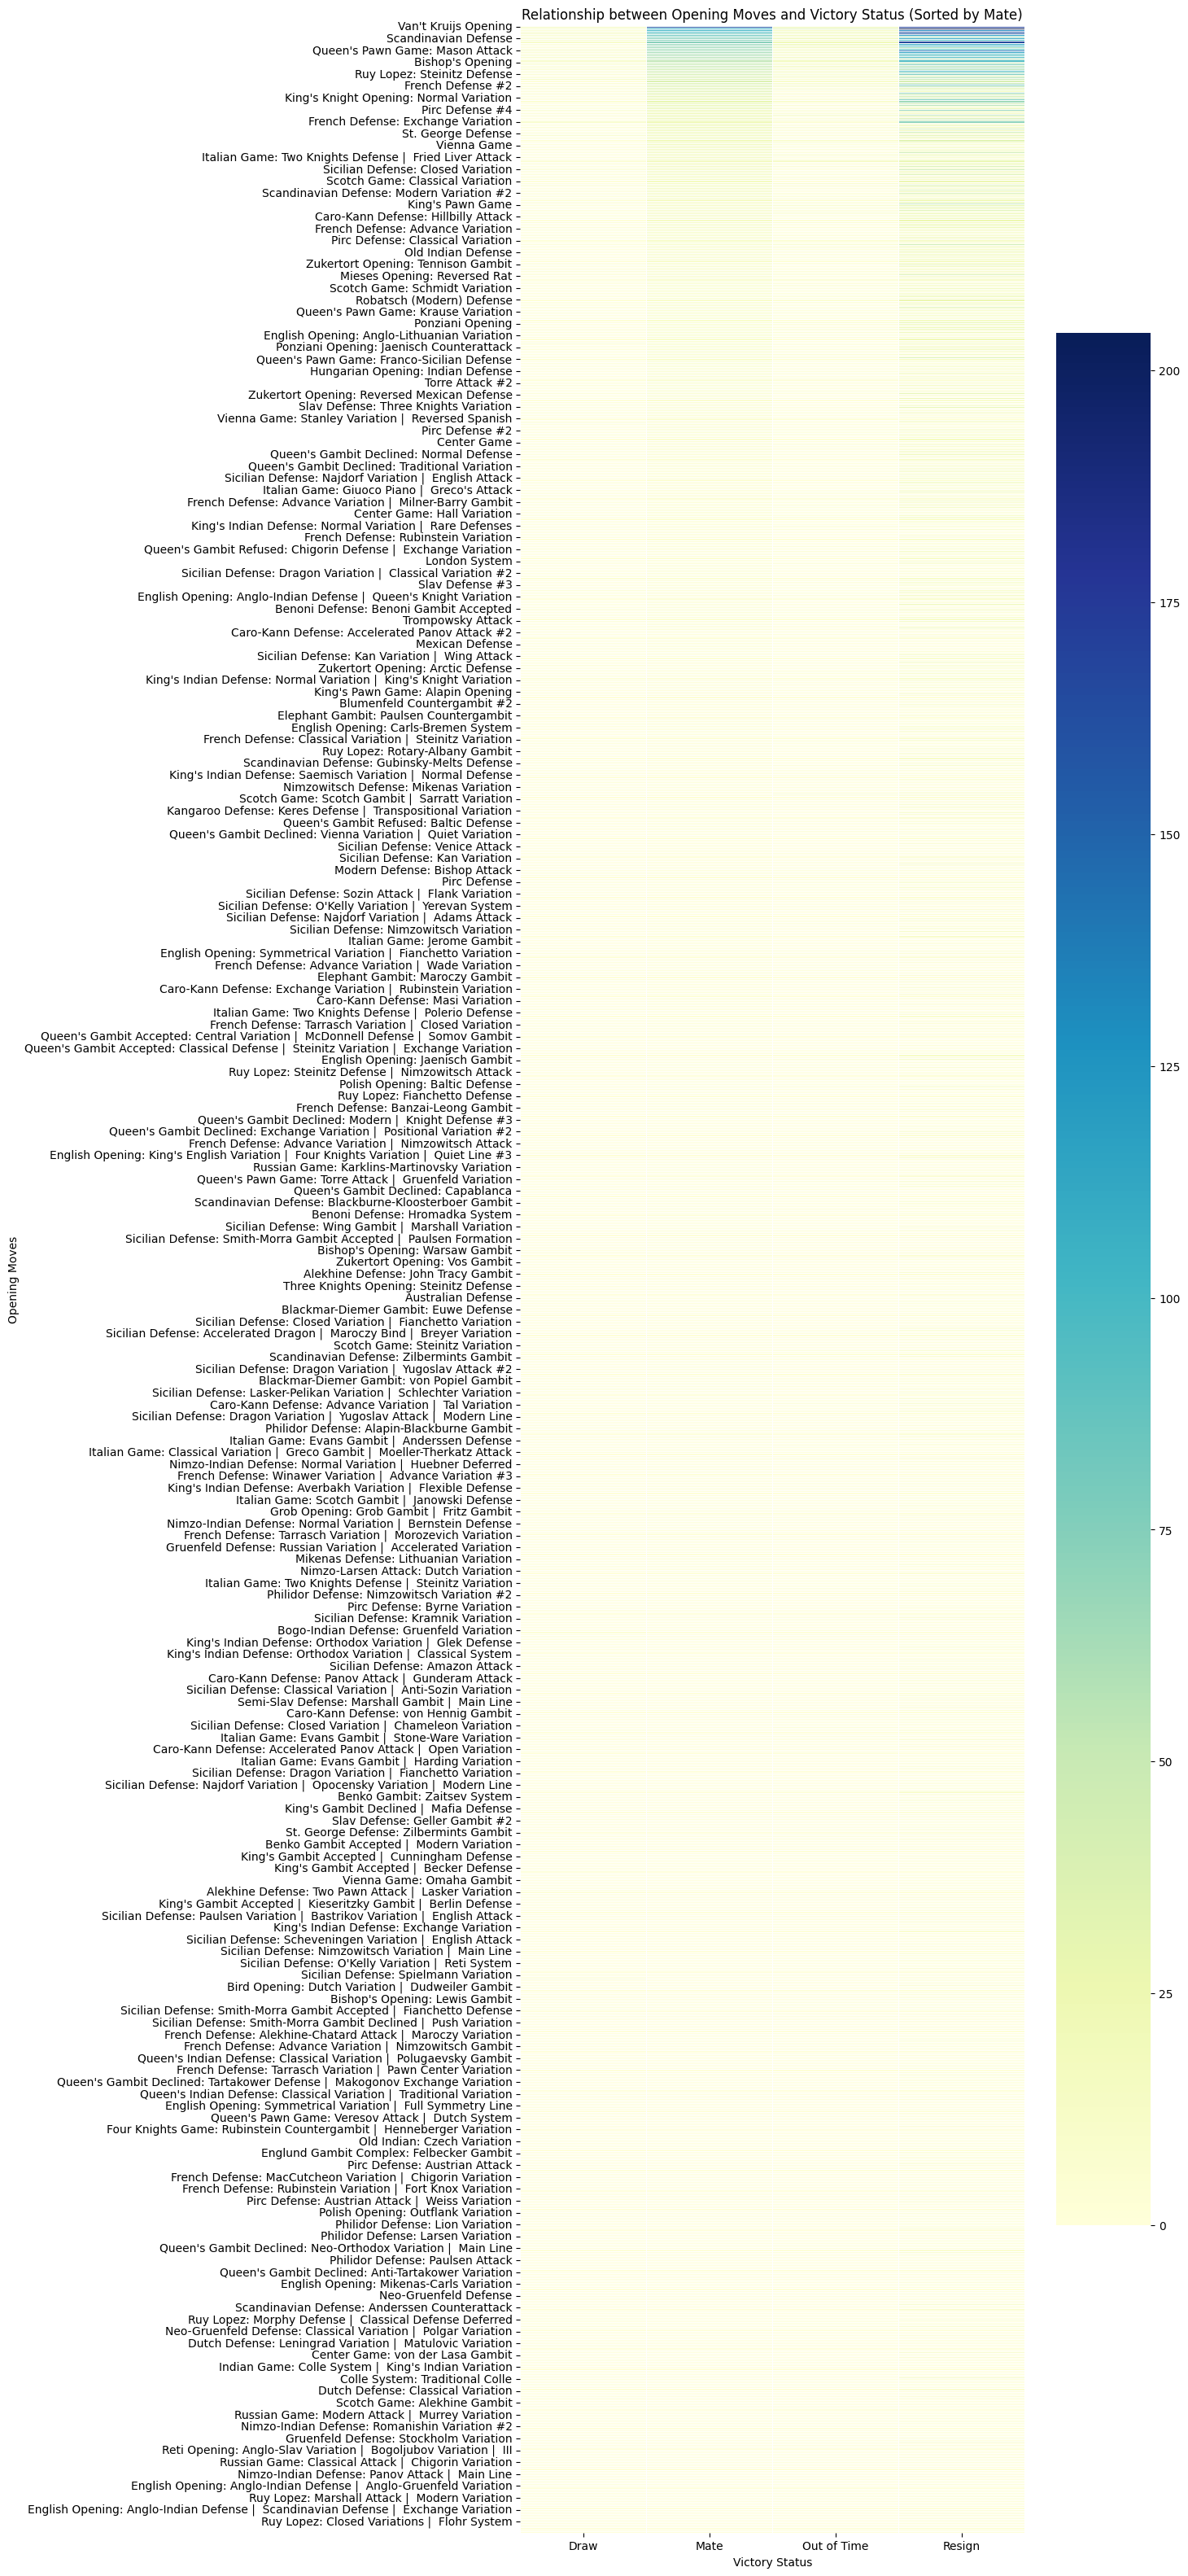

In [9]:
# Create a pivot table to explore the relationship between opening moves and victory status
pivot_table = chess_data.pivot_table(index='opening_fullname', columns='victory_status', aggfunc='size', fill_value=0)

# Sort the pivot table based on the 'Mate' column in descending order
pivot_sorted_by_mate = pivot_table.sort_values(by='Mate', ascending=False)

# Normalize the sorted pivot table by row to see the proportion of victory status for each opening
#pivot_normalized_sorted = pivot_sorted_by_mate.div(pivot_sorted_by_mate.sum(axis=1), axis=0)

# Plotting the heatmap for the sorted data
plt.figure(figsize=(10, 40))
sns.heatmap(pivot_sorted_by_mate, cmap='YlGnBu', linewidths=0.5, fmt='.0%')
plt.title('Relationship between Opening Moves and Victory Status (Sorted by Mate)')
plt.xlabel('Victory Status')
plt.ylabel('Opening Moves')
plt.show()

The heatmap above visualizes the relationship between the opening moves and the victory status in the chess games dataset. Each row represents a different chess opening, and the columns represent the different types of victory statuses (Draw, Mate, Out of Time, Resign). The colour intensity indicates the proportion of each victory status for a given opening, with darker colours indicating higher proportions. This visualization helps in identifying which openings are more likely to lead to certain outcomes.

The heatmap has been updated to visualize the relationship between opening moves and victory status, now sorted based on the descending value of 'Mate' under victory status. This allows for easier identification of which openings are more likely to lead to a checkmate.

# Most Common Moves made by Players

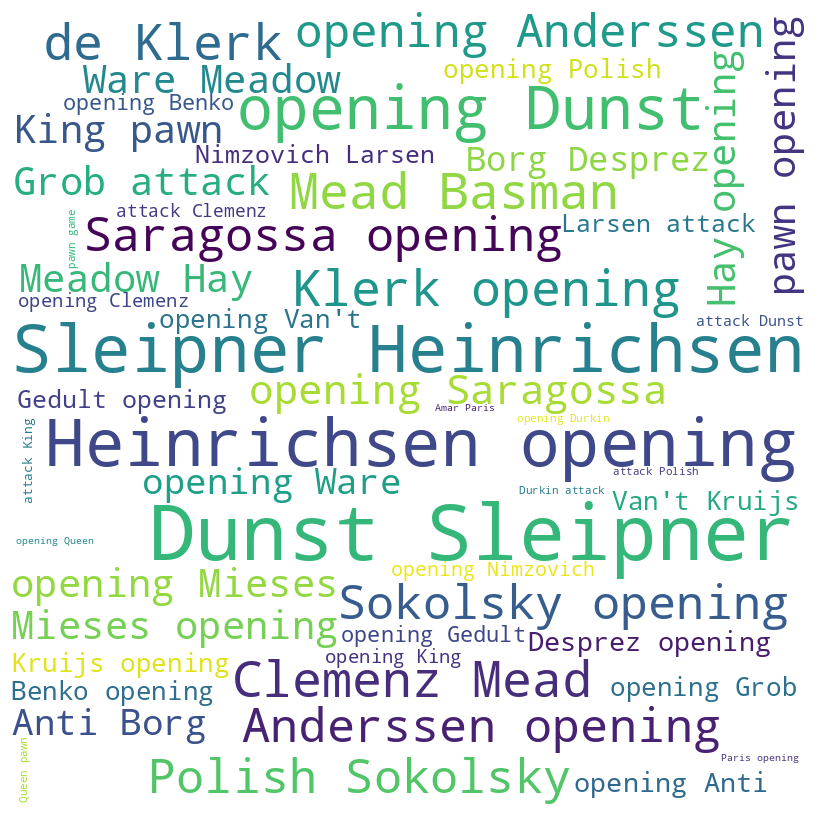

In [10]:
########################### Most Common Move Names ################################

from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Concatenate all move names into a single string
all_moves = ', '.join(chess_data['Move Name'])

# Generate a word cloud image
wordcloud = WordCloud(width = 800, height = 800, 
                background_color ='white', 
                min_font_size = 10).generate(all_moves)

# Plot the WordCloud image                        
plt.figure(figsize = (8, 8), facecolor = None) 
plt.imshow(wordcloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 

plt.show()

The word cloud visualizes the most common move names in the chess games dataset. The size of each move name in the word cloud represents its frequency, with larger sizes indicating more common moves. This visualization helps in quickly identifying the most popular moves among the chess games in the dataset.

# Sequence of moves for a better chance at check-mate.

In [11]:
# Group the data by opening_fullname and count the number of 'Mate' victory status for each opening
mate_counts = chess_data[chess_data['victory_status'] == 'Mate'].groupby('opening_fullname').size()

# Sort the openings by the number of 'Mate' in descending order
sorted_mate_counts = mate_counts.sort_values(ascending=False)

# Get the opening with the highest number of 'Mate'
max_mate_opening = sorted_mate_counts.index[0]

# Create a subset of the dataframe based on the opening move with the highest 'Mate'
subset_highest_mate_sorted = chess_data[(chess_data['opening_fullname'] == max_mate_opening) & (chess_data['victory_status'] == 'Mate')].sort_values(by='turns', ascending=False)

The subset of the dataframe based on the opening moves which has successfully resulted in the highest number of 'Mate' outcomes has been created and ordered by the descending order of the number of turns in each game. This subset contains 154 rows, each representing a chess game that started with the opening move leading to the most 'Mate' outcomes.

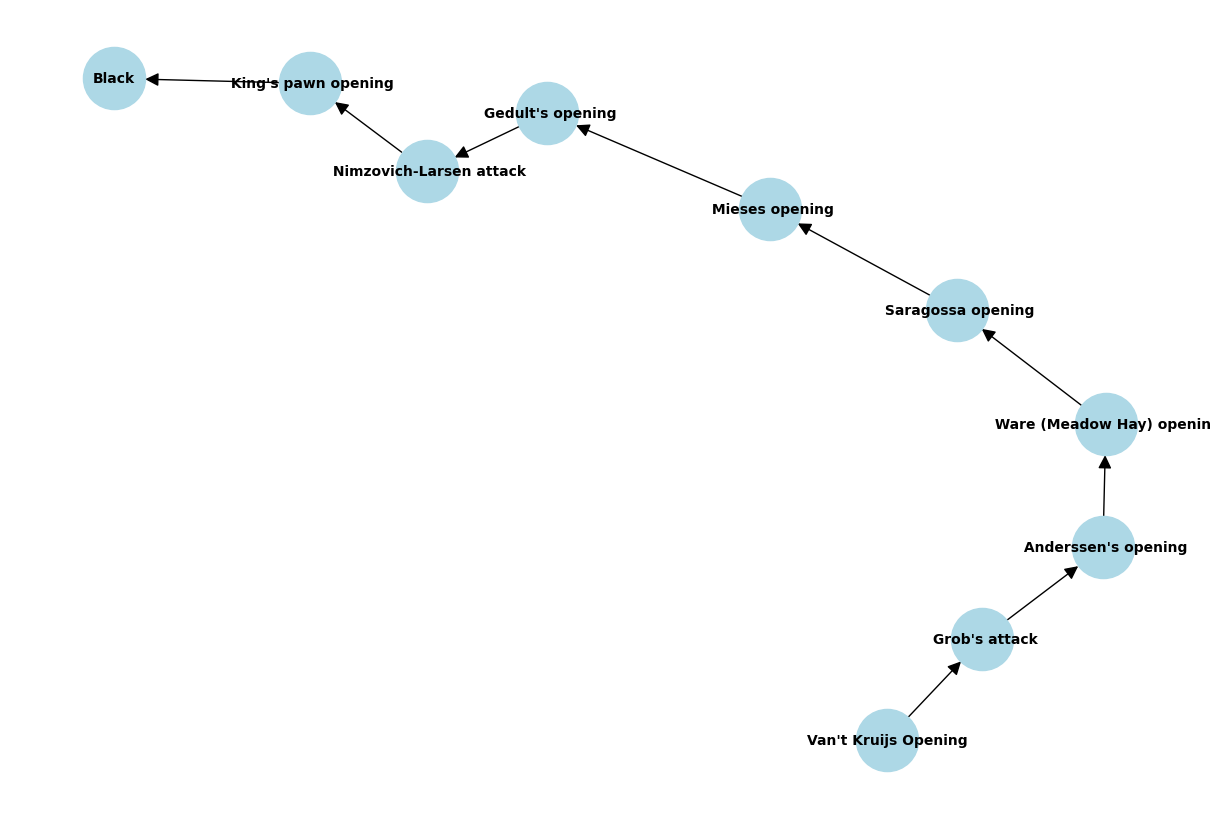

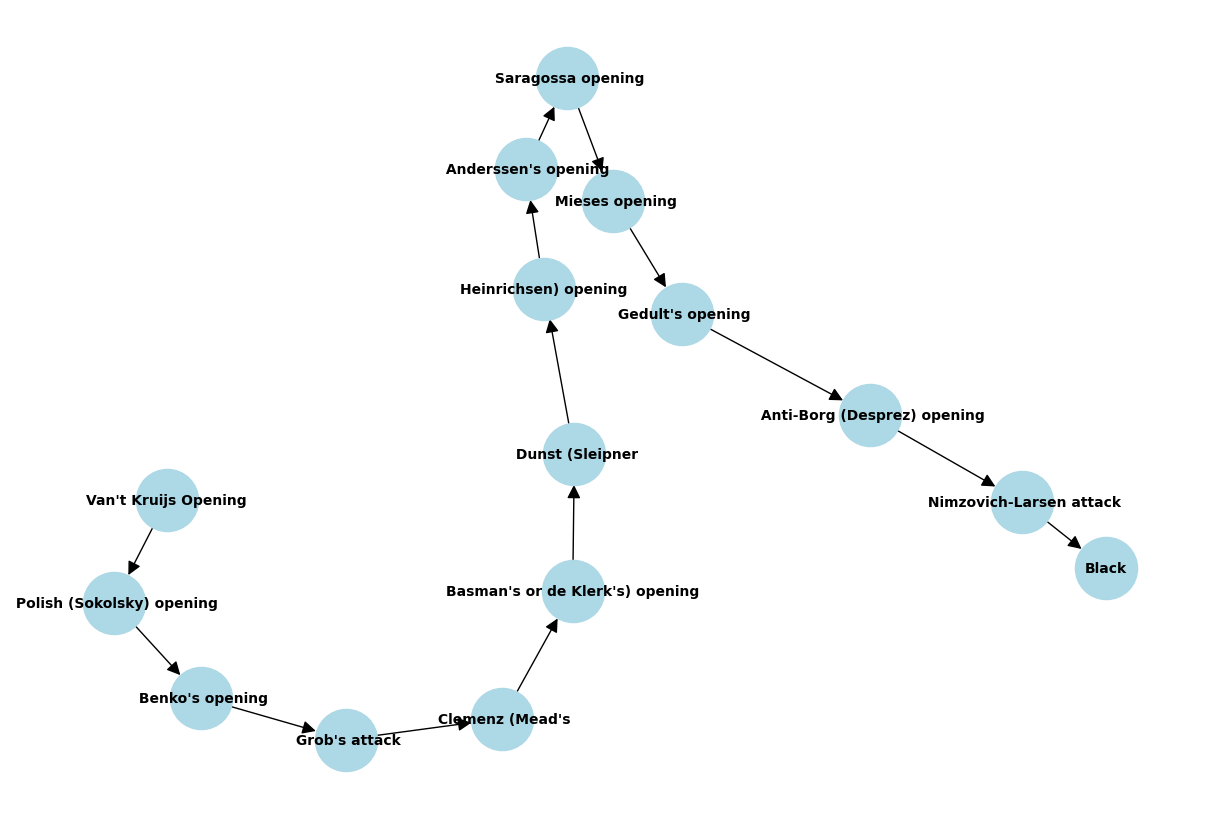

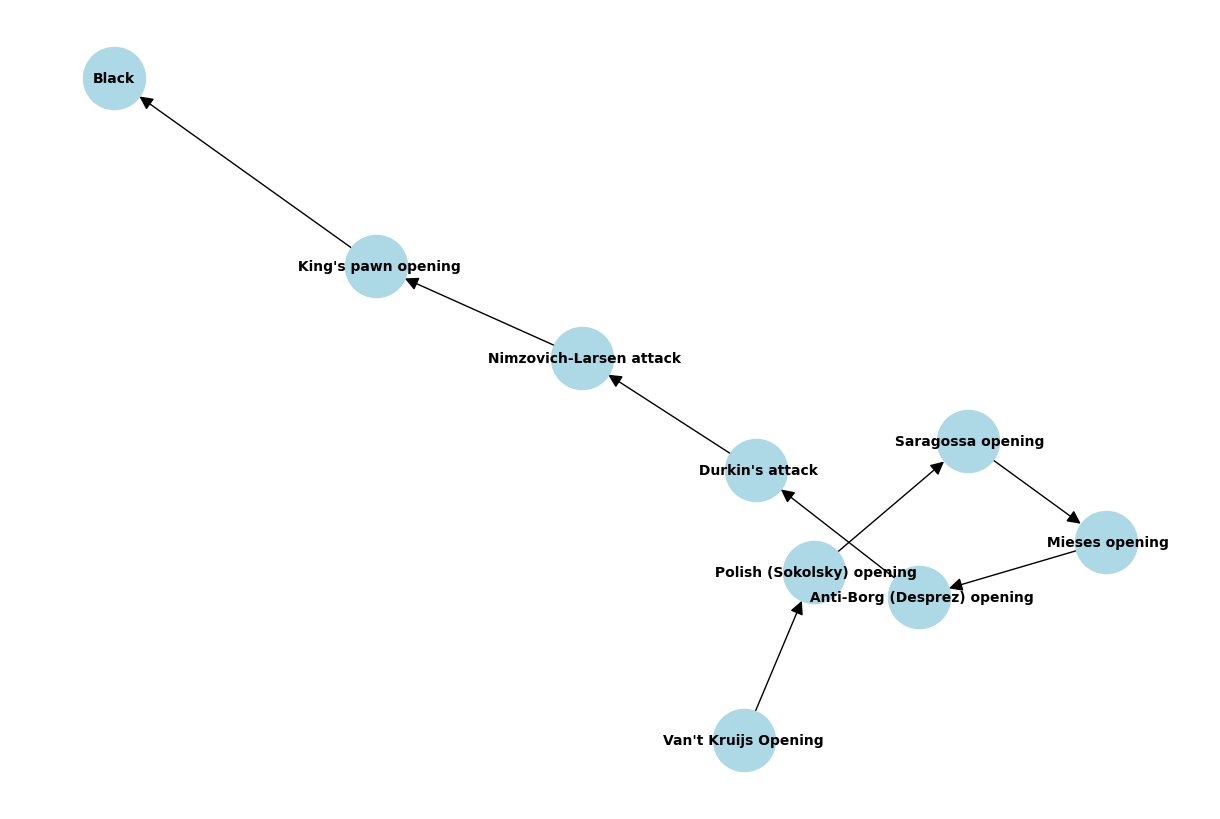

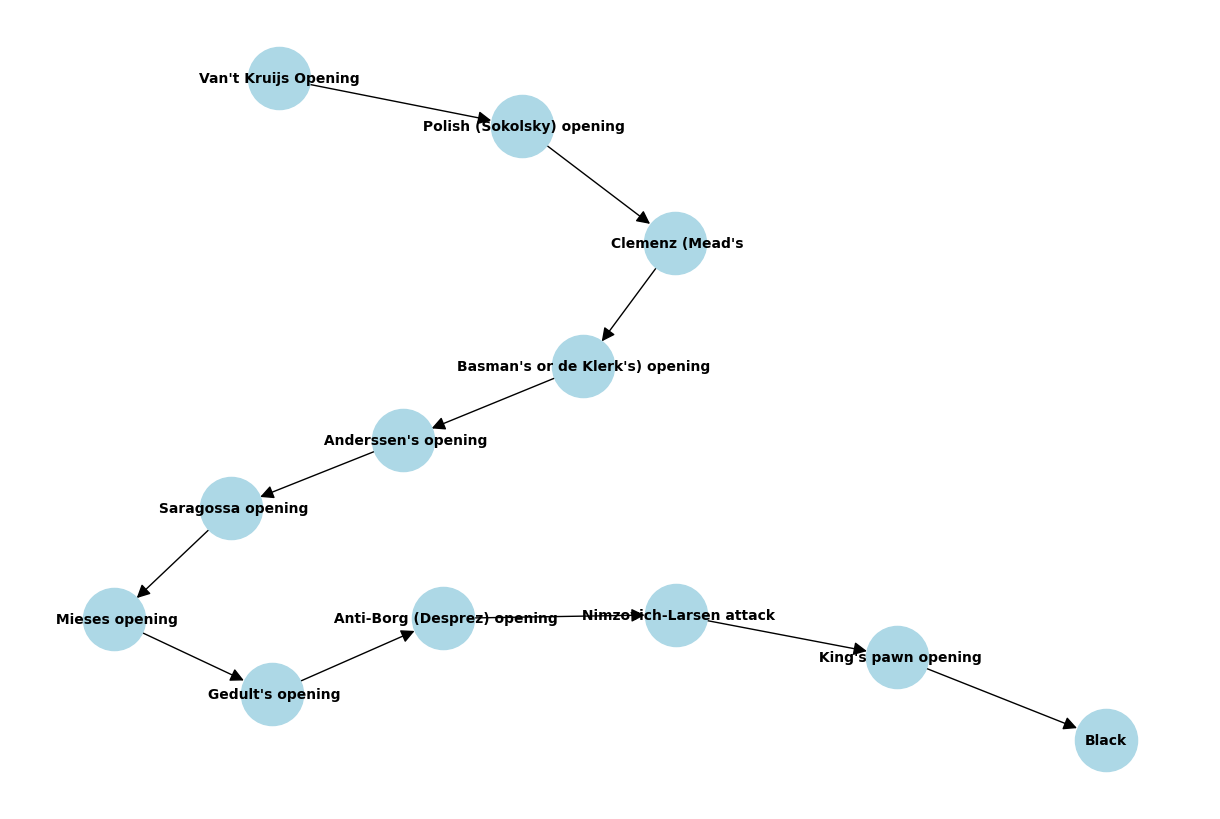

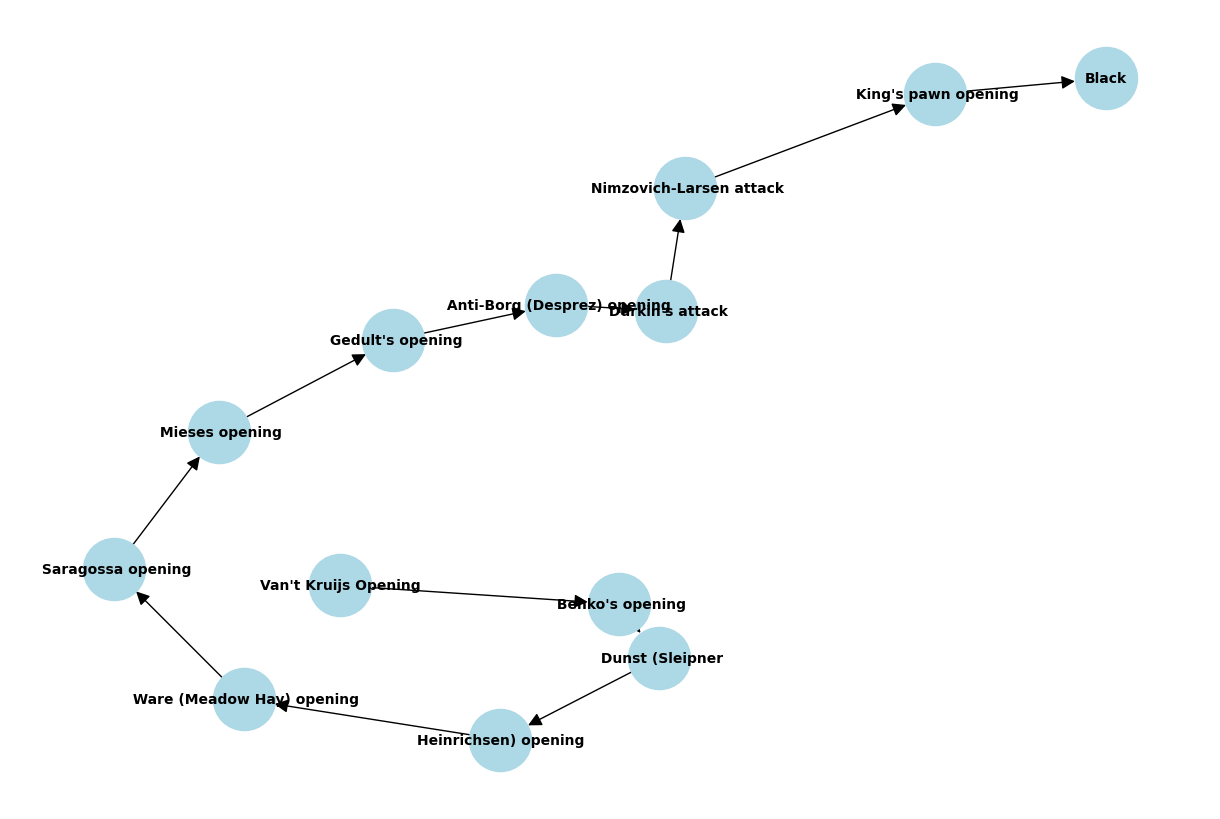

In [12]:
plot_network_for_each_record(subset_highest_mate_sorted.head(5))

The network graphs for the top 5 chess games with the opening move that resulted in the highest number of 'Mate' outcomes have been plotted. Each graph visualizes the progression of moves from the opening to the final victory status, showing the sequence and relationship between moves and the eventual winner.

In [17]:
# Assuming chess_data_subset is already loaded with 'Move Name' column available
# Preprocess the data
moves_sequences = chess_data_subset['Move Name'].str.split(', ')
all_moves = [move for sequence in moves_sequences for move in sequence]
encoder = LabelEncoder()
encoder.fit(all_moves)  # Fit the encoder to all distinct moves from the dataset

# Encode all moves
# Handle unseen labels by first mapping sequences using a lambda that 
# uses 'ignore' to overlook unseen labels during transformation.
encoded_sequences = [encoder.transform(sequence).tolist() for sequence in moves_sequences]

# Simplified Q-learning agent
class ChessQLearningAgent:
    def __init__(self, actions, learning_rate=0.1, discount_factor=0.95, exploration_rate=0.1):
        self.q_table = defaultdict(lambda: np.zeros(len(actions)))
        self.actions = actions
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.exploration_rate = exploration_rate

    def choose_action(self, state):
        if np.random.rand() < self.exploration_rate:
            return np.random.choice(self.actions)
        else:
            return np.argmax(self.q_table[state])

    def learn(self, state, action, reward, next_state):
        q_predict = self.q_table[state][action]
        q_target = reward + self.discount_factor * np.max(self.q_table[next_state])
        self.q_table[state][action] += self.learning_rate * (q_target - q_predict)

# Example of training the agent (highly simplified)
def train_agent(episodes=100):
    agent = ChessQLearningAgent(actions=range(len(encoder.classes_)))

    for episode in range(episodes):
        for sequence in encoded_sequences:
            for i in range(len(sequence) - 1):
                state = sequence[i]
                next_state = sequence[i + 1]
                action = agent.choose_action(state)
                # Simplified reward: +1 for correct move, -1 otherwise
                reward = 1 if action == next_state else -1
                agent.learn(state, action, reward, next_state)

    return agent

# Train the agent
agent = train_agent()

# Function to suggest the next move based on the current sequence of moves
def suggest_next_move(sequence):
    # Transform method updated to handle unseen labels by using a fallback strategy
    # Split the sequence, then transform each move individually using a try-except block
    sequence_list = sequence.split(', ')
    encoded_sequence = []
    for move in sequence_list:
        try:
            encoded_move = encoder.transform([move])[0]
            encoded_sequence.append(encoded_move)
        except ValueError:
            # Handle unseen move by skipping or assigning a default value
            continue

    if encoded_sequence:  # Check if the list isn't empty
        state = encoded_sequence[-1]
        next_move_encoded = agent.choose_action(state)
        next_move = encoder.inverse_transform([next_move_encoded])[0]
        return next_move
    else:
        return "No valid moves provided."

def suggest_next_move_based_on_opening(opening_name):
    # Find all sequences of moves for the given opening
    sequences_for_opening = chess_data_subset[chess_data_subset['opening_fullname'] == opening_name]['Move Name'].str.split(', ')
    if sequences_for_opening.empty:
        return "No games found for this opening."
    
    # Encode the sequences
    encoded_sequences_for_opening = [encoder.transform(sequence).tolist() for sequence in sequences_for_opening]
    
    # Choose a random sequence for simplicity
    chosen_sequence = np.random.choice(encoded_sequences_for_opening)
    
    # Assuming the last move is the state
    state = chosen_sequence[-1]
    
    # Suggest the next move based on the current state
    next_move_encoded = agent.choose_action(state)
    next_move = encoder.inverse_transform([next_move_encoded])[0]
    
    return next_move

def visualize_sequence_network(opening_name):
    sequences_for_opening = chess_data_subset[chess_data_subset['opening_fullname'] == opening_name]['Move Name'].str.split(', ')
    if sequences_for_opening.empty:
        return "No games found for this opening."
    
    chosen_sequence = np.random.choice([sequence for sequence in sequences_for_opening])
    g = nx.DiGraph()
    current_node = opening_name
    g.add_node(current_node)
    for move in chosen_sequence:
        next_node = move
        g.add_edge(current_node, next_node)
        current_node = next_node
    
    plt.figure(figsize=(12, 8))
    nx.draw(g, with_labels=True, node_size=2000, node_color='lightblue', font_size=10, arrowstyle='-|>', arrowsize=20)
    plt.title(f'Sequence Network for {opening_name}')
    plt.show()

/tmp/ipykernel_162/3086531405.py:84: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  chosen_sequence = np.random.choice(encoded_sequences_for_opening)
/tmp/ipykernel_162/3086531405.py:100: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  chosen_sequence = np.random.choice([sequence for sequence in sequences_for_opening])


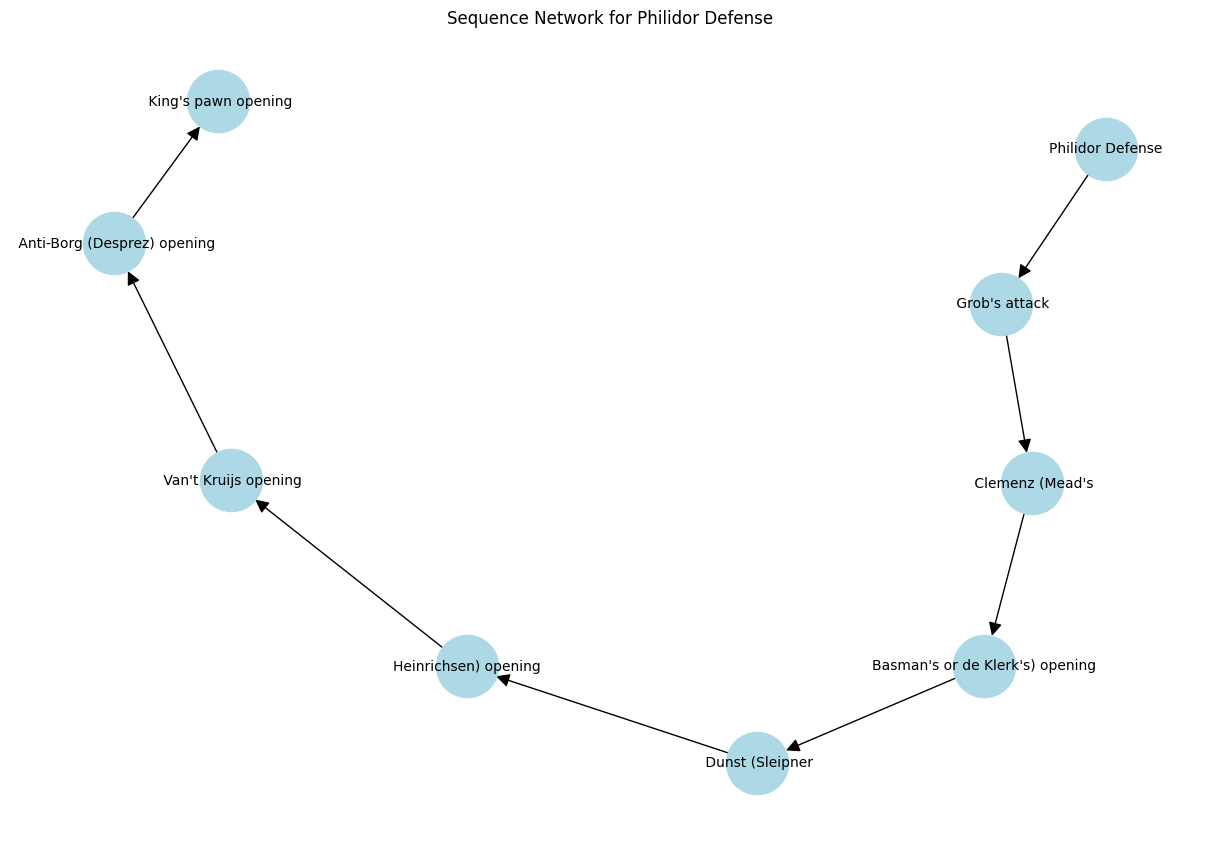

In [18]:
suggested_move_for_opening = suggest_next_move_based_on_opening("Philidor Defense")
#suggested_move_for_opening
visualize_sequence_network('Philidor Defense')

In [15]:
chess_data_subset['opening_fullname'].head(5)

2             King's Pawn Game: Leonardis Variation
3            Queen's Pawn Game: Zukertort Variation
4                                  Philidor Defense
9     Scandinavian Defense: Mieses-Kotroc Variation
10                             Van't Kruijs Opening
Name: opening_fullname, dtype: object

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f7d0eb7a-c53e-46ac-9828-330fe3ad70a0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>